## test_bam_CIGAR

In [1]:
 # --- 配置路径 (请根据你的实际文件名修改) ---
BAM_FILE = "/data/work/human_brain/710_68_1_humanbrain_251209_NB.duplicates.directional.bam"  # 68_1 UMI去重bam
db="/data/work/hg38_annotations.db"

In [3]:
import pysam


def peek_primary_cigar(bam_path, num_reads=30):
    print(f"{'Read Name':<30} | {'CIGAR String'}")
    print("-" * 60)
    
    with pysam.AlignmentFile(bam_path, "rb") as bf:
        count = 0
        for read in bf:
            # 仅查看 Primary Reads (已比对、非次级、非补充)
            if not read.is_unmapped and not (read.is_secondary or read.is_supplementary):
                print(f"{read.query_name[:30]:<30} | {read.cigarstring}")
                
                count += 1
                if count >= num_reads:
                    break


In [4]:
peek_primary_cigar(BAM_FILE)

Read Name                      | CIGAR String
------------------------------------------------------------
250F701086011_4_7525_2472_5707 | 11S60M1D14M1D13M1D5M1D13M1I3M1D4M1D43M1D1M1D52M1I43M1D117M2I48M3D50M1D43M1D14M1D93M1D32M1D11M1D1M2I56M7S
250F701086011_6_3429_5070_9028 | 7S58M2D246M1I24M1D15M2D15M1D86M1I2M2D28M3D3M2D128M1I16M1D23M1D34M1D118M1I165M3S
250F701086011_34_1203_28284_58 | 79S138M4D2M2D17575N77M1D39M1D40M1D10M1D40M2I101M1D39M2I34M1D154M2I33M4S
250F701086011_4_7447_3582_6259 | 11S10M2D52M1D47M1D6M1D30M1I15M1D10M3D25M1D20M2D5M1I5M2D63M1I94M1I103M2I18M2D5M1I56M1I6M1D2M2D8M3I63M3I1M2D19M1D62M1D49M2I98M1I29M1D34M3D87M1D7M3D57M1I7M2I21M1D7M2D14M2I50M1D2M1D5M1I55M1D38M1D10M1I4M2D4M1D2M1D4M1D32M2D96M24D29M2D18M5D35M1I109M4S
250F701086011_3_605_1420_51131 | 307M10S
250F701086011_7_6311_4589_1128 | 168M2D163M2D130M1D40M1I8M1D70M1D23M2I5M1I3M1D24M1I43M1I5M1D42M1I34M3D17M2I3M1I123M1S
250F701086011_1_6304_680_13015 | 11S10M1D22M91N28M2D1M4D117M2D12M2D2M3I4M1I10M1I4M1I3M1I36M2D168M1I5

In [10]:
import pysam
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_clip_stats(bam_path, max_reads=1000000):
    clip_data = []
    print(f"--- 正在提取 Soft-clip 长度 (采样前 {max_reads} 条) ---")
    
    with pysam.AlignmentFile(bam_path, "rb") as bf:
        count = 0
        for read in bf:
            if read.is_unmapped or read.is_secondary or read.is_supplementary:
                continue
            
            cigar = read.cigartuples
            if not cigar: continue
            
            # 4 代表 Soft-clip (S)
            clip_5p = cigar[0][1] if cigar[0][0] == 4 else 0
            clip_3p = cigar[-1][1] if cigar[-1][0] == 4 else 0
            
            clip_data.append({
                '5p_Clip': clip_5p,
                '3p_Clip': clip_3p,
                'Total_Clip': clip_5p + clip_3p
            })
            
            count += 1
            if count >= max_reads: break
            
    df = pd.DataFrame(clip_data)
    
    # 计算统计量
    stats = pd.DataFrame({
        'Median': df.median(),
        'Mean': df.mean()
    })
    
    print("\n" + "="*30)
    print("Soft-clip 统计报告 (单位: bp)")
    print("-" * 30)
    print(stats.round(2))
    print("="*30)
    
    return df, stats

# 运行分析
df_clip, stats_report = analyze_clip_stats(BAM_FILE)

--- 正在提取 Soft-clip 长度 (采样前 1000000 条) ---

Soft-clip 统计报告 (单位: bp)
------------------------------
            Median    Mean
5p_Clip        7.0  113.00
3p_Clip        7.0  108.39
Total_Clip    23.0  221.39


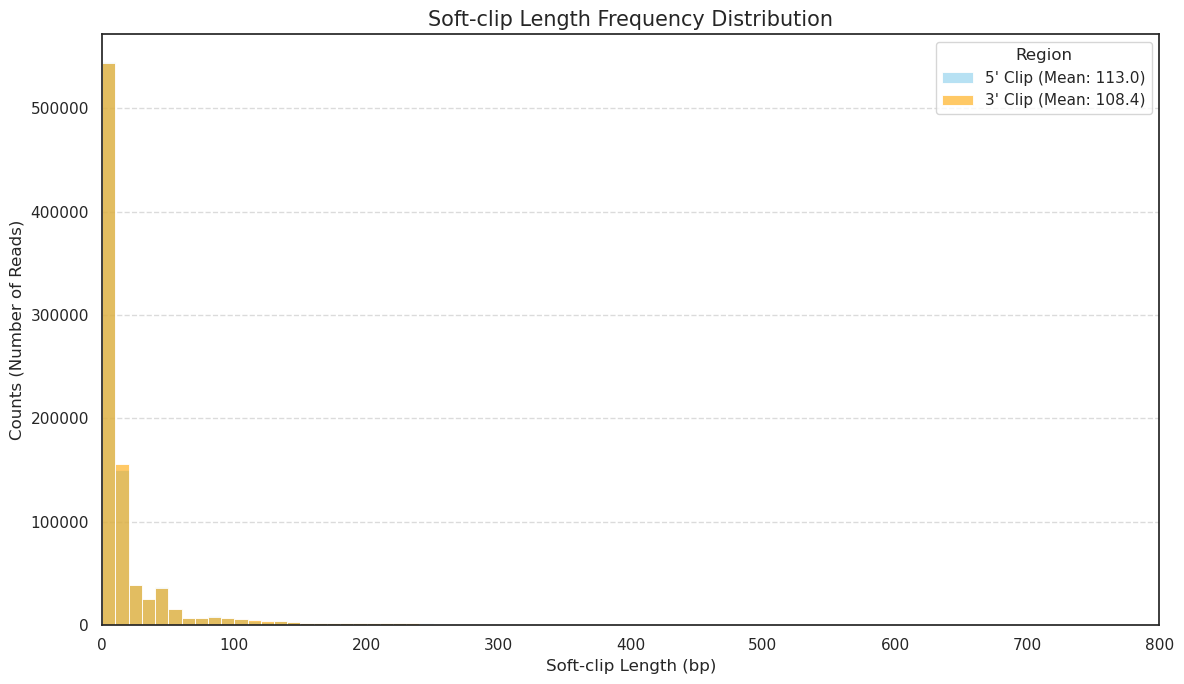

In [11]:
def plot_clip_counts(df):
    sns.set_theme(style="white")
    plt.figure(figsize=(12, 7))
    
    # 设定 bin 宽度，让图表更平滑
    bins = range(0, 1000, 10) 
    
    # 绘制 5' 端分布
    sns.histplot(df['5p_Clip'], bins=bins, color="skyblue", 
                 label=f"5' Clip (Mean: {df['5p_Clip'].mean():.1f})", alpha=0.6)
    
    # 绘制 3' 端分布
    sns.histplot(df['3p_Clip'], bins=bins, color="orange", 
                 label=f"3' Clip (Mean: {df['3p_Clip'].mean():.1f})", alpha=0.6)
    
    # 绘制总 Clip 分布（可选线框形式以作对比）
    # sns.histplot(df['Total_Clip'], bins=bins, color="black", element="step", 
    #              fill=False, label=f"Total Clip (Mean: {df['Total_Clip'].mean():.1f})")

    plt.title("Soft-clip Length Frequency Distribution", fontsize=15)
    plt.xlabel("Soft-clip Length (bp)", fontsize=12)
    plt.ylabel("Counts (Number of Reads)", fontsize=12)
    
    # 限制横坐标范围，避免长尾效应导致主体看不清
    plt.xlim(0, 800) 
    plt.legend(title="Region")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

plot_clip_counts(df_clip)

In [12]:
import pysam

def count_cigar_n_ratio(bam_path, max_reads=None):
    total_primary = 0
    with_n_count = 0
    
    print(f"--- 正在统计 CIGAR 含有 N (剪接信号) 的 Reads 占比 ---")
    
    with pysam.AlignmentFile(bam_path, "rb") as bf:
        for read in bf:
            # 仅统计 Primary Reads
            if read.is_unmapped or read.is_secondary or read.is_supplementary:
                continue
            
            total_primary += 1
            
            # 检查 CIGAR 字符串中是否含有 'N'
            # 方式1: 直接检查字符串 (较快)
            if read.cigarstring and 'N' in read.cigarstring:
                with_n_count += 1
            
            if max_reads and total_primary >= max_reads:
                break
            
            if total_primary % 1000000 == 0:
                print(f"已处理 {total_primary} 条 Reads...")

    ratio = (with_n_count / total_primary) * 100 if total_primary > 0 else 0
    
    print("\n" + "="*40)
    print(f"CIGAR 'N' 统计报告")
    print("-" * 40)
    print(f"Total Primary Reads : {total_primary}")
    print(f"Reads with 'N' (Spliced) : {with_n_count}")
    print(f"Reads without 'N' (Unspliced) : {total_primary - with_n_count}")
    print(f"Spliced Ratio (%)   : {ratio:.2f}%")
    print("="*40)

# 运行统计
count_cigar_n_ratio(BAM_FILE)

--- 正在统计 CIGAR 含有 N (剪接信号) 的 Reads 占比 ---
已处理 1000000 条 Reads...
已处理 2000000 条 Reads...
已处理 3000000 条 Reads...
已处理 4000000 条 Reads...
已处理 5000000 条 Reads...
已处理 6000000 条 Reads...
已处理 7000000 条 Reads...

CIGAR 'N' 统计报告
----------------------------------------
Total Primary Reads : 7662144
Reads with 'N' (Spliced) : 2018052
Reads without 'N' (Unspliced) : 5644092
Spliced Ratio (%)   : 26.34%


In [15]:
import pysam
from intervaltree import IntervalTree

def analyze_n_ratio_by_location(bam_path, db):
    # --- 步骤 1: 构建索引 (复用之前的逻辑) ---
    print("--- 步骤 1: 构建基因结构索引 ---")
    gene_index = {}
    gene_structures = {}
    for gene in db.features_of_type('gene'):
        chrom, strand, g_id = gene.chrom, gene.strand, gene.id
        if chrom not in gene_index: gene_index[chrom] = IntervalTree()
        gene_index[chrom].addi(gene.start, gene.end, g_id)
        
        last_exons = set()
        for tx in db.children(gene, featuretype='transcript'):
            exons = sorted(list(db.children(tx, featuretype='exon')), key=lambda e: e.start)
            if not exons: continue
            le = exons[-1] if strand == '+' else exons[0]
            last_exons.add((le.start, le.end))
        
        gene_structures[g_id] = {'strand': strand, 'last_exons': last_exons, 'g_range': (gene.start, gene.end)}

    # --- 步骤 2: 扫描 BAM 分组统计 ---
    print("--- 步骤 2: 扫描 BAM 并统计 N 比例 ---")
    bf = pysam.AlignmentFile(bam_path, "rb")
    
    # 统计字典: {位置: [总数, 含有N的总数]}
    stats = {
        "Last Exon": [0, 0],
        "Intron": [0, 0]
    }

    for read in bf.fetch(until_eof=True):
        if read.is_unmapped or read.is_secondary or read.is_supplementary:
            continue
        
        chrom = read.reference_name
        matches = gene_index.get(chrom, IntervalTree()).overlap(read.reference_start, read.reference_end)
        if not matches: continue
        
        g_id = list(matches)[0].data
        struct = gene_structures[g_id]
        capture_site = read.reference_end if struct['strand'] == '+' else read.reference_start
        
        # 判定位置
        location = None
        is_last = any(s <= capture_site <= e for s, e in struct['last_exons'])
        if is_last:
            location = "Last Exon"
        else:
            g_s, g_e = struct['g_range']
            if g_s <= capture_site <= g_e:
                # 简单判定为 Intron (排除掉落在最后外显子的都视为广义内含子成分)
                location = "Intron"
        
        if location:
            stats[location][0] += 1 # 总数 +1
            if read.cigarstring and 'N' in read.cigarstring:
                stats[location][1] += 1 # 含有 N 的数量 +1

    bf.close()

    # --- 步骤 3: 输出结果 ---
    print("\n" + "="*50)
    print(f"{'Location':<15} | {'Total Reads':<12} | {'With N':<10} | {'Ratio (%)'}")
    print("-" * 50)
    for loc, counts in stats.items():
        ratio = (counts[1] / counts[0] * 100) if counts[0] > 0 else 0
        print(f"{loc:<15} | {counts[0]:<12d} | {counts[1]:<10d} | {ratio:.2f}%")
    print("="*50)


In [ ]:
import gffutils

# 1. 指向你的数据库文件（.db 文件）
db_path = "/data/work/hg38_annotations.db" 

# 2. 加载数据库对象
db = gffutils.FeatureDB(db_path)

# 3. 现在再调用函数，就不会报错了
analyze_n_ratio_by_location(BAM_FILE, db)

--- 步骤 1: 构建基因结构索引 ---
--- 步骤 2: 扫描 BAM 并统计 N 比例 ---

Location        | Total Reads  | With N     | Ratio (%)
--------------------------------------------------
Last Exon       | 1746481      | 709298     | 40.61%
Intron          | 5695706      | 1168022    | 20.51%


In [18]:
import pysam
import gffutils
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from intervaltree import IntervalTree

def analyze_contiguous_intron_overlap(bam_path, db):
    # --- 步骤 1: 构建内含子区间索引 ---
    print("--- 正在提取基因组内含子坐标索引 ---")
    intron_index = {}
    for gene in db.features_of_type('gene'):
        chrom = gene.chrom
        strand = gene.strand
        exons = sorted(list(db.children(gene, featuretype='exon')), key=lambda e: e.start)
        if len(exons) < 2: continue
        
        if chrom not in intron_index:
            intron_index[chrom] = IntervalTree()
            
        for i in range(len(exons) - 1):
            i_start, i_end = exons[i].end + 1, exons[i+1].start - 1
            if i_end > i_start:
                # 存储区间和链信息
                intron_index[chrom].addi(i_start, i_end, (i_start, i_end, strand))

    # --- 步骤 2: 扫描 BAM 逐 Read 解析 CIGAR ---
    print("--- 正在解析长读长在内含子内的连续比对长度 ---")
    bf = pysam.AlignmentFile(bam_path, "rb")
    results = []

    for read in bf.fetch(until_eof=True):
        if read.is_unmapped or read.is_secondary or read.is_supplementary:
            continue
        
        chrom = read.reference_name
        # 10x 长读长捕获位点判定
        capture_site = read.reference_end if not read.is_reverse else read.reference_start
        
        # 找到当前捕获点所在的内含子
        matches = intron_index.get(chrom, IntervalTree()).at(capture_site)
        if not matches: continue
        
        for m in matches:
            i_start, i_end, strand = m.data
            
            # 解析 CIGAR 获取在基因组上的连续比对段
            # 我们需要的是从捕获端开始的那一段连续比对长度
            cigar = read.cigartuples
            if not cigar: break
            
            # 如果是正向比对且在正链，或者反向比对且在负链，捕获点在 Read 序列的末尾
            # 我们根据 CIGAR 从捕获位点那一侧向另一侧累加，直到遇到 N
            ops = cigar[::-1] if not read.is_reverse else cigar
            
            contiguous_len_on_genome = 0
            current_pos = capture_site
            
            for op, length in ops:
                if op in (0, 7, 8): # M, =, X (匹配)
                    contiguous_len_on_genome += length
                elif op == 2: # D (缺失，在基因组上占长度)
                    contiguous_len_on_genome += length
                elif op == 1: # I (插入，在基因组上不占长度，但在 cDNA 上占)
                    pass 
                elif op == 3: # N (跳跃/剪接)
                    break # 遇到剪接点，停止统计连续部分
                elif op == 4: # S (Soft clip)
                    continue
                
                # 检查是否跑出了内含子边界
                temp_pos = capture_site - contiguous_len_on_genome if not read.is_reverse else capture_site + contiguous_len_on_genome
                if not (i_start <= temp_pos <= i_end):
                    # 如果超过了边界，截断到边界处
                    contiguous_len_on_genome -= abs(temp_pos - (i_start if not read.is_reverse else i_end))
                    break
            
            results.append(max(0, contiguous_len_on_genome))
            break 

    bf.close()
    return pd.DataFrame({'contiguous_overlap_bp': results})

# df_res = analyze_contiguous_intron_overlap(BAM_FILE, db)

In [19]:
df_res = analyze_contiguous_intron_overlap(BAM_FILE, db)

--- 正在提取基因组内含子坐标索引 ---
--- 正在解析长读长在内含子内的连续比对长度 ---


In [24]:
def plot_contiguous_overlap(df):
    plt.figure(figsize=(10, 6))
    sns.histplot(df['contiguous_overlap_bp'], bins=100, color='darkred', kde=True)
    
    plt.title("Contiguous Alignment Length within the Current Intron", fontsize=13)
    plt.xlabel("Contiguous Length in Intron (bp)", fontsize=12)
    plt.ylabel("Counts", fontsize=12)
    
    # 标注长读长的特征值
    plt.axvline(df['contiguous_overlap_bp'].mean(), color='blue', linestyle='--', 
                label=f"Mean: {df['contiguous_overlap_bp'].mean():.1f}bp")
    
    plt.legend()
    plt.show()
    

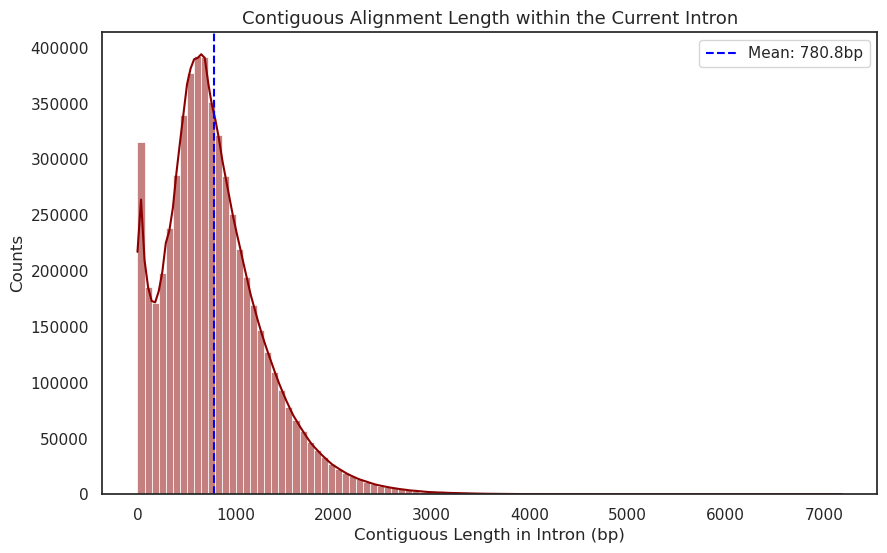

In [25]:
plot_contiguous_overlap(df_res)

## 检验BAM文件中是否有基因标识  GX表示read对应的gene ID

In [2]:
import pysam
from collections import Counter

def inspect_bam_gene_tags(bam_path, read_limit=20000):
    """
    专门用于探测 BAM 文件中基因标识标签的工具函数。
    它会扫描前 read_limit 条比对记录，并汇总所有可选标签及其内容。
    """
    try:
        bf = pysam.AlignmentFile(bam_path, "rb")
    except Exception as e:
        print(f"无法打开文件: {e}")
        return

    # 计数器：记录标签出现的频率
    tag_frequency = Counter()
    # 示例库：记录每个标签的前 3 个不同取值，方便人工确认内容
    tag_samples = {}

    print(f"正在扫描: {bam_path}")
    print(f"扫描范围: 前 {read_limit} 条 Primary Alignments...\n")

    processed_count = 0
    for read in bf.fetch(until_eof=True):
        # 过滤掉未比对和次要比对，只看主要比对的标签
        if read.is_unmapped or read.is_secondary or read.is_supplementary:
            continue
            
        tags = read.get_tags()
        for tag_name, tag_value in tags:
            tag_frequency[tag_name] += 1
            
            # 记录示例（每个标签存 3 个不同的值）
            if tag_name not in tag_samples:
                tag_samples[tag_name] = set()
            if len(tag_samples[tag_name]) < 3:
                tag_samples[tag_name].add(str(tag_value))
        
        processed_count += 1
        if processed_count >= read_limit:
            break
            
    bf.close()

    if not tag_frequency:
        print("警告：在扫描范围内没有找到任何可选标签！")
        return

    # --- 打印结果表格 ---
    header = f"{'Tag':<6} | {'Count':<10} | {'Frequency':<10} | {'Sample Values'}"
    print(header)
    print("-" * len(header) * 2)

    for tag, count in tag_frequency.most_common():
        freq = f"{(count / processed_count) * 100:>6.1f}%"
        samples = " | ".join(tag_samples[tag])
        print(f"{tag:<6} | {count:<10} | {freq:<10} | {samples}")

    print("-" * len(header) * 2)

    # --- 智能判定 ---
    # 定义生物信息学中常见的基因相关标签
    # GX/GN: CellRanger/STAR; XT: featureCounts; ge/gN: Long-read tools
    potential_gene_tags = {'GX', 'GN', 'XT', 'ge', 'gN', 'gene_id', 'gene_name'}
    found_potential = [t for t in tag_frequency if t in potential_gene_tags]

    if found_potential:
        print(f"\n✅ 找到可能的基因标识标签: {', '.join(found_potential)}")
        print(f"建议：在后续分析中使用 read.get_tag('{found_potential[0]}') 进行快速检索。")
    else:
        print("\n❌ 未发现常见的基因标识标签。")
        print("提示：如果列表中只有 AS, NM, MD, NH 等，说明该 BAM 尚未进行基因指派（Assignment）。")
        print("建议：请先使用 featureCounts 或同类软件处理 BAM，或继续使用之前的 IntervalTree 检索逻辑。")

# --- 使用方法 ---
# inspect_bam_gene_tags("你的数据.bam")

In [3]:
inspect_bam_gene_tags(BAM_FILE)

正在扫描: /data/work/human_brain/710_68_1_humanbrain_251209_NB.duplicates.directional.bam
扫描范围: 前 20000 条 Primary Alignments...

Tag    | Count      | Frequency  | Sample Values
------------------------------------------------------------------------------------------------
NM     | 20000      |  100.0%    | 37 | 28 | 33
ms     | 20000      |  100.0%    | 640 | 615 | 877
AS     | 20000      |  100.0%    | 613 | 605 | 874
nn     | 20000      |  100.0%    | 0
tp     | 20000      |  100.0%    | P
cm     | 20000      |  100.0%    | 133 | 184 | 153
s1     | 20000      |  100.0%    | 539 | 746 | 558
s2     | 20000      |  100.0%    | 557 | 726 | 575
de     | 20000      |  100.0%    | 0.029200000688433647 | 0.04479999840259552 | 0.027699999511241913
MD     | 20000      |  100.0%    | 7G50^GC253T16^C15^TC15^C88^TC28^TAA3^TC0T75C52T1C12^T23^G0T33^C147T0C69G54A0A0G7 | 7T0C73A28T9T16^GCTC2^AA35A41^T39^G40^T1A8^T15T88T36^G44T28^A187 | 60^C7A0A5^G13^C5^T16^T4^T6A34A1^T1^A95^A132G32^CTG33A0G11A3^T0G42^G